## This notebook is to train the model with best hyperparameter and run some evaluation on the latent space

In [1]:
import torch
import numpy as np
import glob
import os
from os.path import join as opj
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import tqdm
from dataset import TimeSeriesDataset
from models import MaskedAutoencoder, MaskedAutoencoderLightning
from utils import get_model_output,evaluate_reconstructions
from sklearn.model_selection import train_test_split
import wandb
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint


random_seed = 42

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import importlib
import utils
importlib.reload(utils)
from utils import get_model_output,evaluate_reconstructions

In [2]:
# define the data path
data_path = "/srv/nfs-data/janeway/UDGSL_Dataset/HCP"
target_path =  "/srv/nfs-data/janeway/fMRI_foundation_model_ICA_BEST"

# choose the ica dimensionality
d_in = 25
ica = f"ica{d_in}"

#get the list of subjects
file_list = glob.glob(opj(data_path,ica,"*.npy"))

# split the data into training and testing
train_list, test_list = train_test_split(file_list, test_size=0.2, random_state=random_seed)

In [3]:
# create the datasets

train_dataset = TimeSeriesDataset(train_list)
test_dataset = TimeSeriesDataset(test_list)



In [4]:
N_EPOCHS = 5000
WARMUP_EPOCHS = 500 

In [5]:
wandb.login()
wandb.init(project="ICA Foundation Model")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante. Use `wandb login --relogin` to force relogin


In [6]:
## best hyperparmeters

batch_size= 128

d_model = 512
dim_feedforward = 512
dropout = 0.1
learning_rate = 0.0001
mask_ratio = 0.5
masked_loss = False

nhead = 4
num_decoder_layers = 3
num_encoder_layers = 6
patch_size = 60
weight_decay = 0

In [ ]:


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## compute steps
steps_per_epoch = len(train_loader.dataset) // batch_size 
total_steps = steps_per_epoch * N_EPOCHS
warmup_steps = steps_per_epoch * WARMUP_EPOCHS

#Define folder for saving the model checkpoints
checkpoint_dir = os.path.join(target_path, wandb.run.name)
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks for early stopping and checkpointing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop after 3 epochs without improvement
    verbose=True,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,  # Save in the unique run folder
    filename='{epoch:02d}-{val_loss:.2f}',  # File format
    monitor='val_loss',  # Monitor validation loss
    save_top_k=1,  # Save only the best model
    mode='min',  # Minimize the val_loss
    verbose=True
)




# Initialize your model with the hyperparameters from the sweep config
model = MaskedAutoencoderLightning(
    patch_size=patch_size,  # You can modify this as per your use case
    d_in=d_in,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers, #to make the decoder shallower
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    masked_loss=masked_loss,  # Adjust this if necessary
    mask_ratio=mask_ratio,
    warmup_steps=warmup_steps,
    max_steps=total_steps  # You can calculate or adjust this based on your dataset
)

# Initialize PyTorch Lightning trainer with WandB logger
wandb_logger = WandbLogger()  # Use WandB as logger
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=N_EPOCHS,  # Adjust the number of epochs as needed
    devices = [3],
    log_every_n_steps=steps_per_epoch, ## Log every epoch,
    callbacks=[early_stopping, checkpoint_callback],  # Add callbacks

    )




# Assuming you have your dataloader defined (train_loader)
trainer.fit(model, train_loader, test_loader)

print("Running evaluation")
reconstructions, ground_truths, masks, latents, labels = get_model_output(model,test_loader)

avg_r2, avg_pearson, avg_mse = evaluate_reconstructions(ground_truths,reconstructions)

wandb.log({"R2" : avg_r2, "Pearson Correlation" : avg_pearson, "MSE" : avg_mse})
print({"R2" : avg_r2, "Pearson Correlation" : avg_pearson, "MSE" : avg_mse})



In [16]:
masks.mean()

tensor(0.0875)

## See some reconstructions

In [9]:
masks_extended = torch.repeat_interleave(masks,patch_size,1)


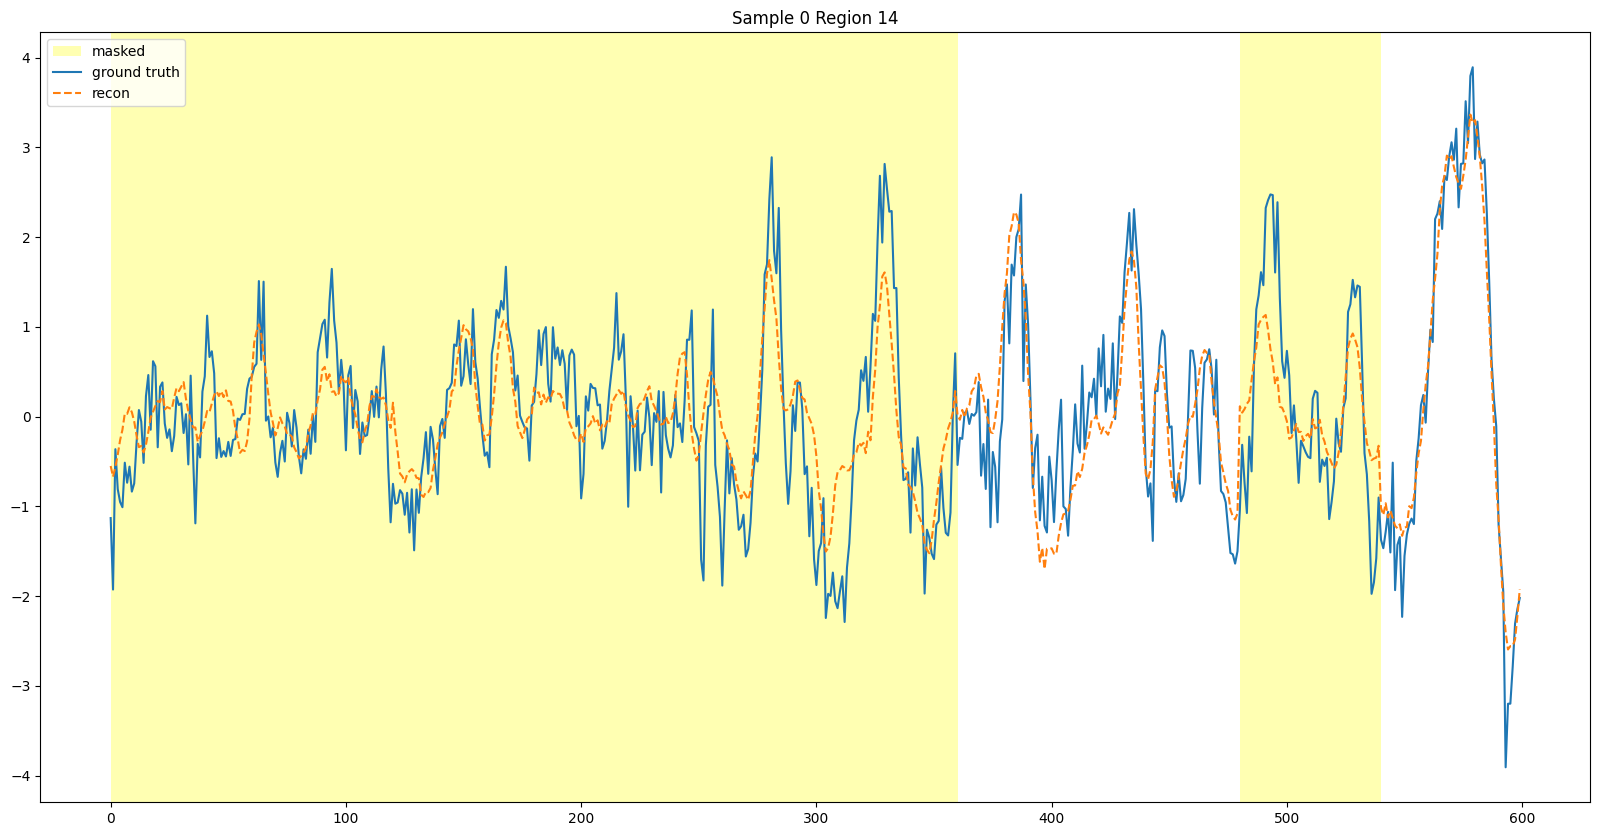

In [30]:
sample_idx = 0
region_idx = 14

how_many_points = 600

fig, axs = plt.subplots(1,1, figsize = (20,10))

mask_sample = masks[sample_idx][:how_many_points,region_idx]


for i, m in enumerate(mask_sample):
    
    if m.item() == 1.0:
        start = i * patch_size
        end = (i + 1) * patch_size
                    
        if start>= how_many_points-patch_size:
            break
        if i>0:
            axs.axvspan(start, end, facecolor='yellow', alpha=0.3)

        else:
            axs.axvspan(start, end, facecolor='yellow', alpha=0.3,label="masked")

            
axs.plot(ground_truths[sample_idx, :how_many_points, region_idx],label="ground truth")
axs.plot(reconstructions[sample_idx, :how_many_points, region_idx],"--",label = "recon")
axs.set_title(f"Sample {sample_idx} Region {region_idx}")
axs.legend()


In [18]:
train_reconstructions, train_ground_truths, train_masks, train_latents, train_labels = get_model_output(model,train_loader)
reconstructions, ground_truths, masks, latents, labels = get_model_output(model,test_loader)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.45it/s]


## visualize some latent


Text(0.5, 0, 'Time (patch idx)')

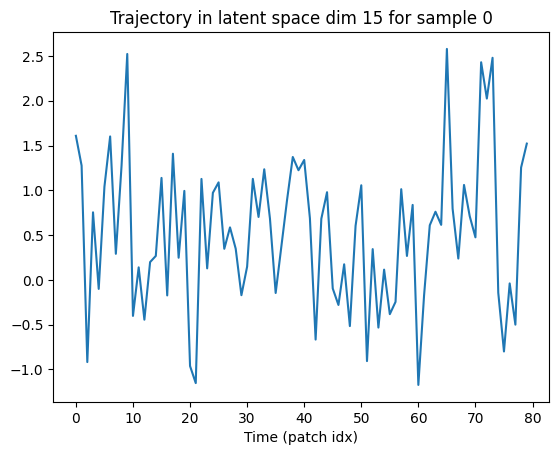

In [38]:

latent_dim_to_vis = 15
latent_sample = 0

plt.plot(latents[latent_sample,:,latent_dim_to_vis])
plt.title(f"Trajectory in latent space dim {latent_dim_to_vis} for sample {latent_sample}")
plt.xlabel("Time (patch idx)")

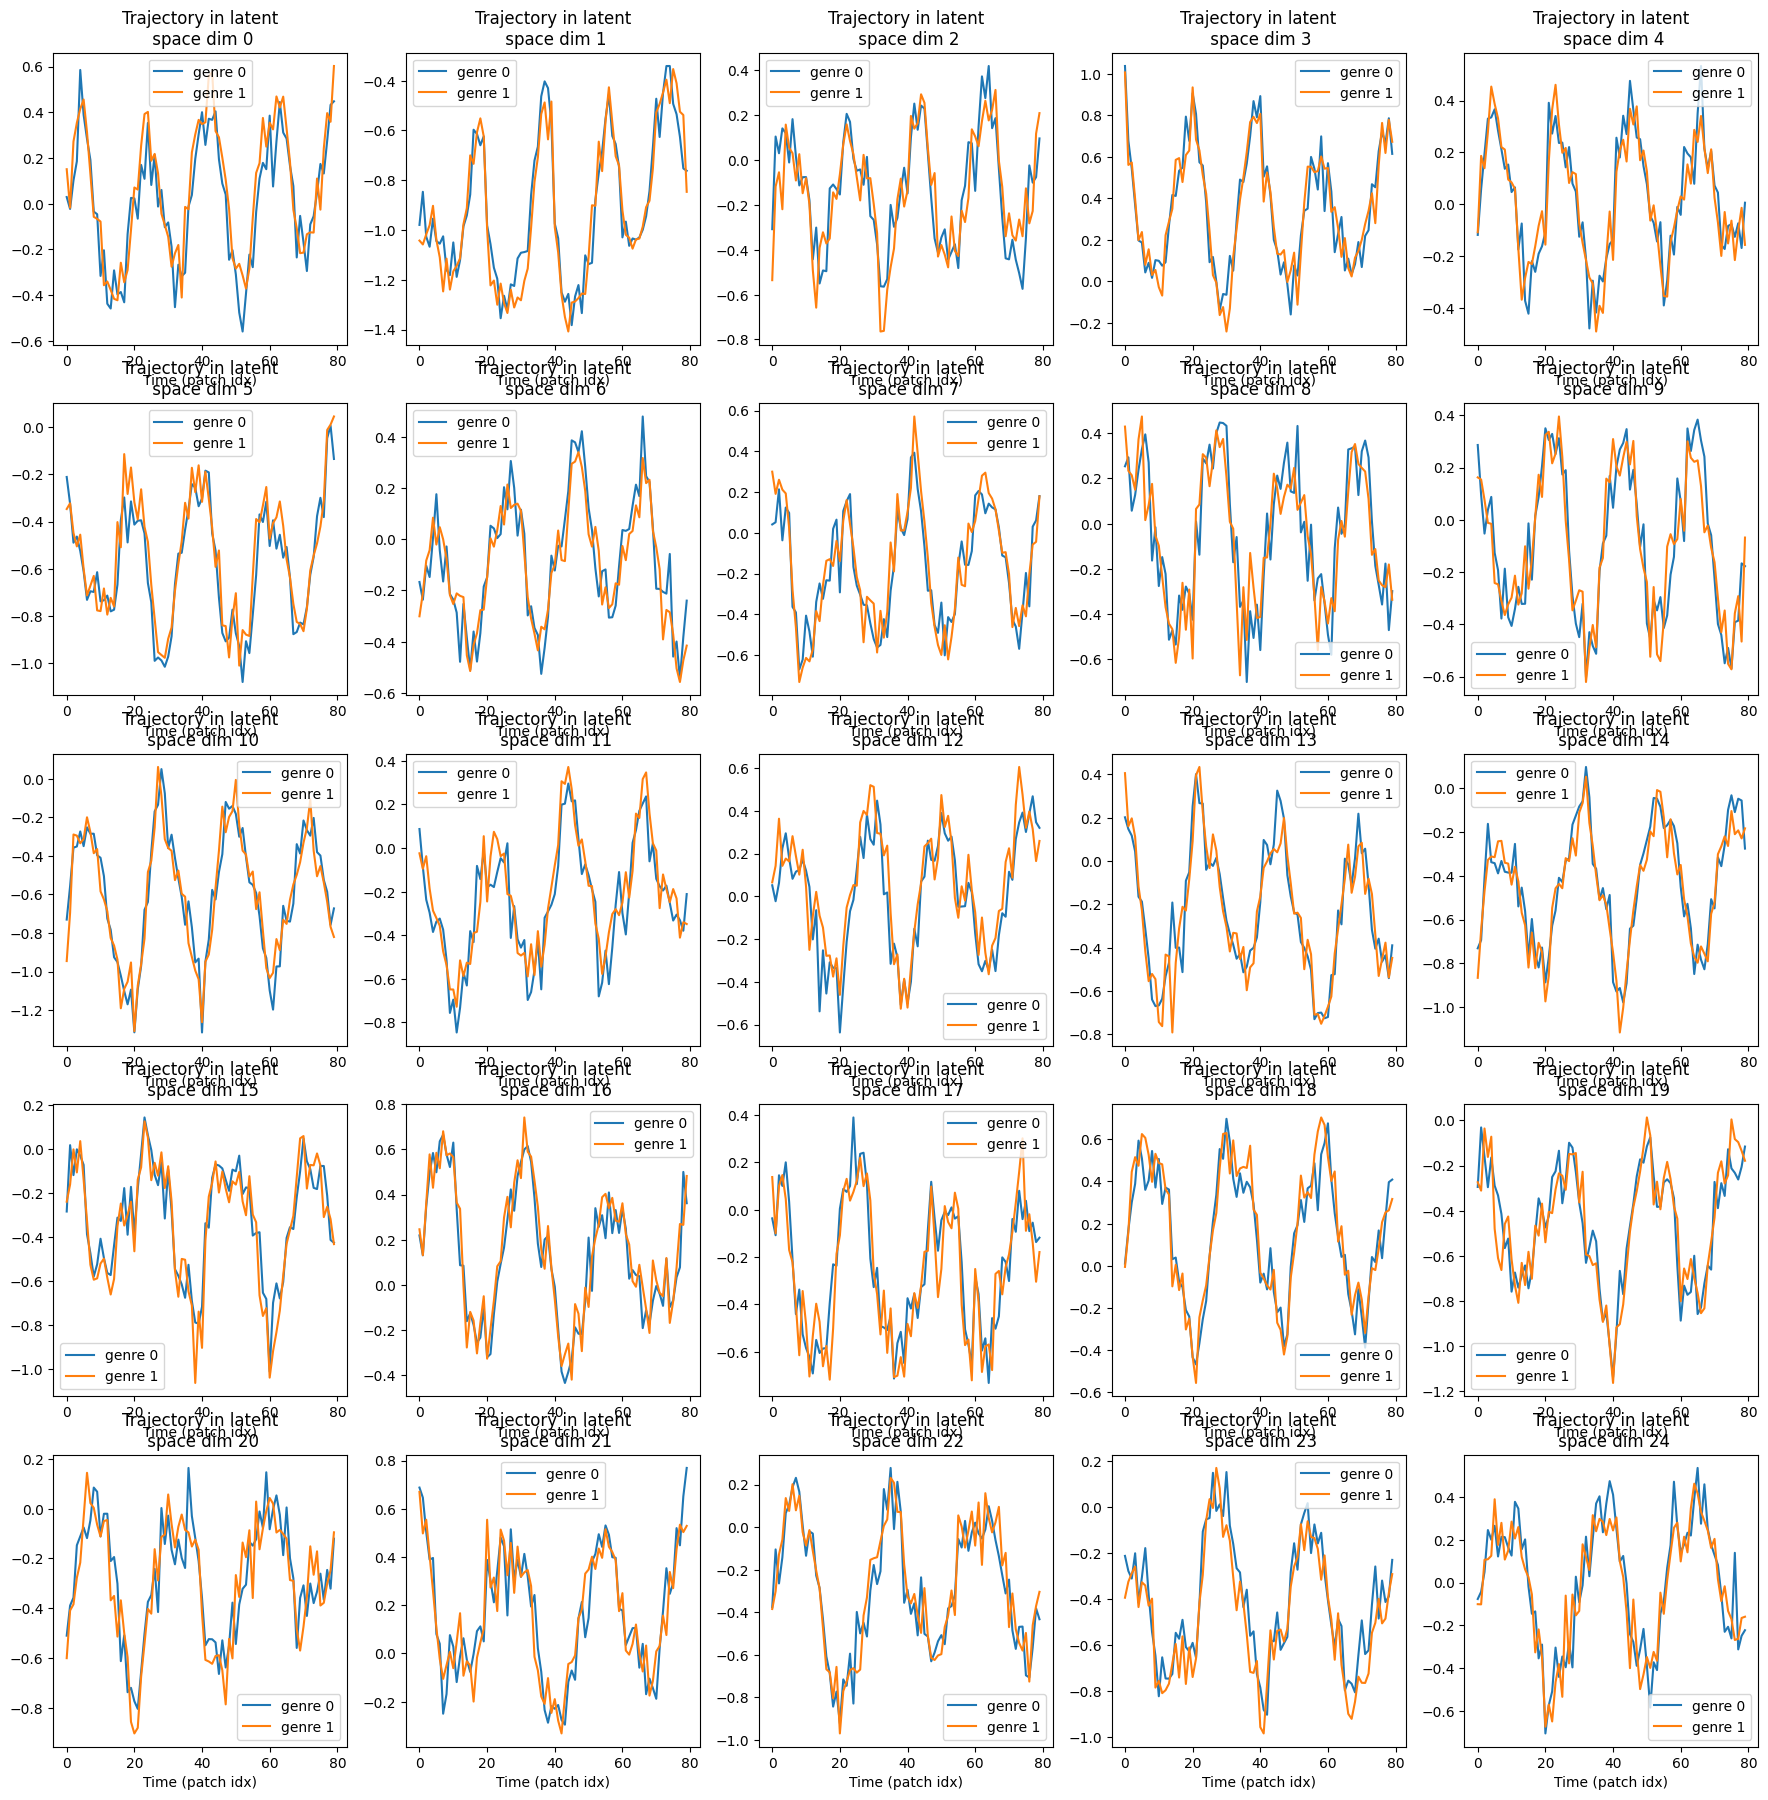

In [65]:
fig, axs = plt.subplots(5,5, figsize=(22,22))

offset = 60
for i, ax in enumerate(axs.ravel()):
    ax.plot(latents[labels==0].mean(0)[:,i+offset], label="genre 0")

    ax.plot(latents[labels==1].mean(0)[:,i+offset], label="genre 1")
    ax.set_title(f"Trajectory in latent\n space dim {i}")
    ax.legend()
    ax.set_xlabel("Time (patch idx)")

In [78]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [68]:
# %pip install mne

In [79]:
clf =  LogisticRegression(max_iter=1000)
sliding_clf = SlidingEstimator(clf, n_jobs=-1, scoring='accuracy')

sliding_clf.fit(train_latents.permute(0,2,1), train_labels)  ## should be (N, d, t)

y_pred = sliding_clf.predict(latents.permute(0,2,1))

acc = [] 

for i in range(y_pred.shape[-1]): #loop over time
    acc.append(accuracy_score(labels.numpy(),y_pred[:,i]))

100%|███████████████████████████████████████████████████████████████████████████████████████████| Fitting SlidingEstimator : 80/80 [00:00<00:00,   99.70it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████| Transforming SlidingEstimator : 80/80 [00:00<00:00,  606.31it/s]


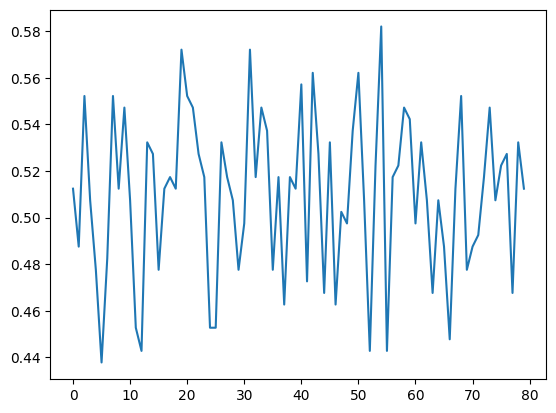

In [81]:
plt.plot(acc)

### Same with original data

100%|███████████████████████████████████████████████████████████████████████████████████████| Fitting SlidingEstimator : 4800/4800 [00:01<00:00, 2954.71it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| Transforming SlidingEstimator : 4800/4800 [00:00<00:00, 8314.69it/s]


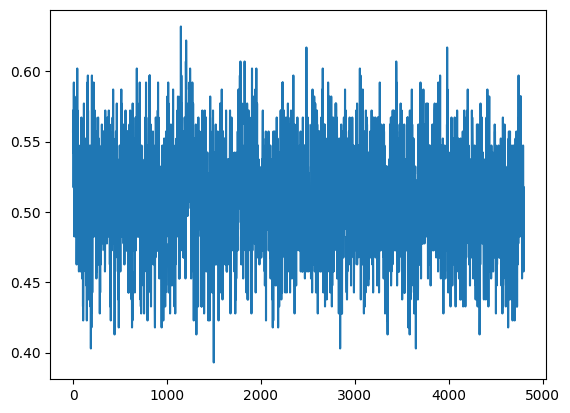

In [83]:
clf =  LogisticRegression(max_iter=1000)
sliding_clf = SlidingEstimator(clf, n_jobs=-1, scoring='accuracy')

sliding_clf.fit(train_ground_truths.permute(0,2,1), train_labels)  ## should be (N, d, t)

y_pred = sliding_clf.predict(ground_truths.permute(0,2,1))

acc = [] 

for i in range(y_pred.shape[-1]): #loop over time
    acc.append(accuracy_score(labels.numpy(),y_pred[:,i]))
    
plt.plot(acc)

## Use more complex approaches

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer


class TimeSeriesCNN(pl.LightningModule):
    def __init__(self, input_size, channels = 128,num_classes=2):
        super(TimeSeriesCNN, self).__init__()
        
        # CNN architecture using Conv1d layers for time series data
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=channels, kernel_size=5, padding=1)
        self.conv2 = nn.Conv1d(in_channels=channels, out_channels=2*channels, kernel_size=5, padding=1)
        self.conv3 = nn.Conv1d(in_channels=2*channels, out_channels=4*channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.LazyLinear(2*channels)
        self.fc2 = nn.LazyLinear(num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        
        
        # Input shape: (batch_size, num_channels, sequence_length)
        x = x.permute(0,2,1)
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten the output from Conv layers
        x = torch.mean(x, dim=-1)  # Global average pooling (alternative to flatten)
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.loss_fn(outputs, y)
        self.log('train_loss', loss,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.loss_fn(outputs, y)
        acc = (outputs.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss,prog_bar=True)
        self.log('val_acc', acc,prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=5e-4)
        return optimizer


In [116]:
cnn_baseline_model = TimeSeriesCNN(input_size=d_in, num_classes=2)

# Create PyTorch Lightning trainer
trainer = Trainer(max_epochs=18, devices=[1])

# Train the model
trainer.fit(cnn_baseline_model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv1d           | 16.1 K | train
1 | conv2   | Conv1d           | 164 K  | train
2 | conv3   | Conv1d           | 393 K  | train
3 | pool    | MaxPool1d        | 0      | train
4 | fc1     | LazyLinear       | 0      | train
5 | fc2     | LazyLinear       | 0      | train
6 | relu    | ReLU             | 0      | train
7 | dropout | Dropout          | 0      | train
8 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
573 K     Trainable params
0         Non-trainable params
573 K     Total params
2.296     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.75it/s, v_num=16, train_loss=0.715]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.52it/s, v_num=16, train_loss=0.690, val_loss=0.691, val_acc=0.522]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.65it/s, v_num=16, train_loss=0.679, val_loss=0.691, val_acc=0.522]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|█████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s, v_num=16, train_loss=0.377, val_loss=0.396, val_acc=0.826]


In [103]:
from sklearn.metrics import classification_report
import torch

# Function to get predictions for the entire dataset
def predict_and_store(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in tqdm.tqdm(data_loader):
            x, y = batch
            x = x.to(model.device)  # Move data to the same device as the model
            y = y.to(model.device)
            
            # Get predictions
            outputs = model(x)
            preds = outputs.argmax(dim=1)  # Get the predicted class index
            
            # Store predictions and ground truth
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU
            all_labels.extend(y.cpu().numpy())     # Move ground truth to CPU
    
    return all_preds, all_labels


In [117]:
# Assuming `train_loader` is the DataLoader for the training set
predictions, ground_truth = predict_and_store(cnn_baseline_model, test_loader)

# Print classification report
print(classification_report(ground_truth, predictions))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s]

              precision    recall  f1-score   support

           0       0.77      0.90      0.83        96
           1       0.89      0.76      0.82       105

    accuracy                           0.83       201
   macro avg       0.83      0.83      0.83       201
weighted avg       0.83      0.83      0.83       201



In [118]:
train_latents_dataset = torch.utils.data.TensorDataset(train_latents,train_labels)
test_latents_dataset = torch.utils.data.TensorDataset(latents,labels)

latent_train_loader = torch.utils.data.DataLoader(train_latents_dataset, batch_size = batch_size, shuffle=True)
latent_test_loader = torch.utils.data.DataLoader(test_latents_dataset, batch_size = batch_size, shuffle=True)


In [122]:
cnn_latents_model = TimeSeriesCNN(input_size=d_model, num_classes=2)

# Create PyTorch Lightning trainer
trainer = Trainer(max_epochs=10, devices=[1])

# Train the model
trainer.fit(cnn_latents_model, latent_train_loader, latent_test_loader)

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv1d           | 327 K  | train
1 | conv2   | Conv1d           | 164 K  | train
2 | conv3   | Conv1d           | 393 K  | train
3 | pool    | MaxPool1d        | 0      | train
4 | fc1     | LazyLinear       | 0      | train
5 | fc2     | LazyLinear       | 0      | train
6 | relu    | ReLU             | 0      | train
7 | dropout | Dropout          | 0      | train
8 | loss_fn | CrossEntropyLoss | 0      | train
---

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 85.61it/s, v_num=19, train_loss=0.711]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.15it/s, v_num=19, train_loss=0.698, val_loss=0.692, val_acc=0.522]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00, 78.10it/s, v_num=19, train_loss=0.694, val_loss=0.692, val_acc=0.522]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.41it/s, v_num=19, train_loss=0.186, val_loss=0.941, val_acc=0.567]


In [123]:
# Assuming `train_loader` is the DataLoader for the training set
predictions, ground_truth = predict_and_store(cnn_latents_model, latent_test_loader)

# Print classification report
print(classification_report(ground_truth, predictions))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 86.14it/s]

              precision    recall  f1-score   support

           0       0.53      0.94      0.67        96
           1       0.80      0.23      0.36       105

    accuracy                           0.57       201
   macro avg       0.66      0.58      0.51       201
weighted avg       0.67      0.57      0.51       201

